# Time-Windows labeling

This notebook shows how to compute time-windows flares binary labels and how to verify the performances of a persistence model
     

# Libraries

In [2]:
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle



# Flare catalog import

In [3]:
# Here plutino catalog (https://doi.org/10.5281/zenodo.10560189) can be replaced by other catalog
path_flare_catalog = "/Users/greg/Google Drive/Mi unidad/Projects/Forecast/Datasets/Events_Catalogs/flare_catalog_2023_04__1986_01.csv"

start_date         = pd.to_datetime('2020-01-26 00:00:00')
end_date           = pd.to_datetime('2023-04-21 22:00:00')

flare_start_col    = 'timestamp'
flare_start_col_fmt= '%Y-%m-%d %H:%M:%S'

flCatalog = pd.read_csv(path_flare_catalog)
flCatalog[flare_start_col] = flCatalog[flare_start_col].apply(lambda x: datetime.datetime.strptime(x,flare_start_col_fmt))
flCatalog = flCatalog.set_index(flare_start_col,drop=True)
flCatalog = flCatalog[(flCatalog.index >= start_date)  & (flCatalog.index <= end_date)]
flCatalog

,tstart,tpeak,tend,BG_flux,peak_flux,fclass,multipleID,integral,singleID,flux_integral,flux_integral_net,fl_net,supclass,supclass_net,cat,cat_net
timestamp,,,,,,,,,,,,,,,,
2020-01-26 03:08:28,2020-01-26 03:08:28,2020-01-26 03:13:04,2020-01-26 03:19:52,1.224800e-07,1.510600e-07,B1.5,221014,NaN,332733,0.000093,0.000086,2.858000e-08,B1,A2,B,A
2020-01-26 08:33:04,2020-01-26 08:33:04,2020-01-26 08:37:40,2020-01-26 08:44:28,1.216500e-07,1.442000e-07,B1.4,221015,NaN,332734,0.000091,0.000084,2.255000e-08,B1,A2,B,A
2020-01-28 00:09:40,2020-01-28 00:09:40,2020-01-28 00:19:52,2020-01-28 00:30:52,1.132600e-07,1.366200e-07,B1.4,221018,NaN,332735,0.000159,0.000147,2.336000e-08,B1,A2,B,A
2020-01-28 05:06:04,2020-01-28 05:06:04,2020-01-28 05:14:16,2020-01-28 05:26:40,1.213600e-07,1.648200e-07,B1.6,221019,NaN,332736,0.000180,0.000167,4.346000e-08,B1,A4,B,A
2020-01-28 06:55:04,2020-01-28 06:55:04,2020-01-28 07:00:04,2020-01-28 07:06:04,1.206300e-07,1.423600e-07,B1.4,221020,NaN,332737,0.000087,0.000080,2.173000e-08,B1,A2,B,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-21 17:22:04,2023-04-21 17:22:04,2023-04-21 17:35:28,2023-04-21 17:38:16,6.942800e-07,9.923200e-07,B9.9,237771,0.000820,358505,NaN,NaN,2.980400e-07,B9,B3,B,B
2023-04-21 17:38:16,2023-04-21 17:38:16,2023-04-21 18:13:04,2023-04-21 19:32:40,9.847600e-07,1.764200e-05,M1.8,237771,0.057021,358506,NaN,NaN,1.665724e-05,M1,M1,M,M
2023-04-21 19:32:40,2023-04-21 19:32:40,2023-04-21 19:36:28,2023-04-21 20:18:28,4.062900e-06,4.271200e-06,C4.3,237771,0.008078,358507,NaN,NaN,2.083000e-07,C4,B2,C,B


# Time-windows labeling function

## Method 1 : Pandas rolling windows

We also propose a method 2 (slower) based on straightforward loops for people unfamiliar with pandas

In [4]:
%%time

# Method used in the paper, simplifided version of the function sundl.utils.flare.windowHistoryFromFlList 
# In the paper code we separately comput the windows history (24h  backward) from windowHistoryFromFlList(),
# we then convert them into windows labels (24h forwark) with an index offset direclty during the dataset instantiation in sundl.dataloaders.sdocml.builDS_image_feature 
# Here we directly merge these two  steps for simplicity

def windows_labeling_pandas(flCatalog, # flare catalogg
                            window_h, # time-windows sizes in hour
                            timeRes_h, # temporal cadence at which to compute time-windows labels
                            minDate = None, 
                            maxDate = None,
                            colPeakFlux = 'peak_flux',
                            binary_labels = ['C+','M+'],
                            binar_thresholds  =  {'C+' : 1e-6, 'M+' : 1e-5},
                            forward = True # to obtain windows labels, i.e. next 24h if 'window_h=24' (otherwhise we get the history (backward 24h))
                            ):
  """
  """
  flares = flCatalog.copy()

  freq = f'{timeRes_h}h'
  window =  f'{window_h}h'
  features = {}

  features['mpf']   = flares[colPeakFlux].resample(freq, label ='right', closed='right').max()
  if window_h > timeRes_h:
    features['mpf']  = features['mpf'].rolling(window, closed = 'right').max()
  features  = pd.DataFrame(features)
    
  features[f'mpf_previous'] = features['mpf'].rolling(
                                                window = f'{window_h}H',
                                                closed = 'left', 
                                                ).apply(lambda x: x[0])
    
  for binLabel in binary_labels:
    features[binLabel] = features['mpf'].apply(lambda x: x>= binar_thresholds[binLabel])
    features[f'{binLabel}_previous'] = features['mpf_previous'].apply(lambda x: x>= binar_thresholds[binLabel])
    features[f'{binLabel}_AC'] = features[binLabel] != features[f'{binLabel}_previous']
    features[f'{binLabel}_NC'] = ~features[f'{binLabel}_AC']
    
  if forward:
    features.index = features.index + pd.DateOffset(hours= -window_h)
    

      
  features = features[2*int(window_h/timeRes_h):].fillna(0) 
  
  if minDate is not None:
    features = features[(features.index>=minDate)]
  if maxDate is not None:
    features = features[(features.index<=maxDate)]
    
  return features
     
windows_pandas = windows_labeling_pandas(flCatalog = flCatalog.copy(), # flare catalogg
                                         window_h = 24, # time-windows sizes in hour
                                         timeRes_h = 2 , # temporal cadence at which to compute time-windows labels
                                         minDate = pd.to_datetime('2020-01-28 00:00:00'), 
                                         maxDate = pd.to_datetime('2023-04-16 22:00:00'))   
            
windows_pandas

<timed exec>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


CPU times: user 927 ms, sys: 28.3 ms, total: 955 ms
Wall time: 1.08 s


,mpf,mpf_previous,C+,C+_previous,C+_AC,C+_NC,M+,M+_previous,M+_AC,M+_NC
timestamp,,,,,,,,,,
2020-01-28 00:00:00,1.648200e-07,0.000000e+00,False,False,False,True,False,False,False,True
2020-01-28 02:00:00,1.648200e-07,1.366200e-07,False,False,False,True,False,False,False,True
2020-01-28 04:00:00,1.648200e-07,1.366200e-07,False,False,False,True,False,False,False,True
2020-01-28 06:00:00,1.591100e-07,1.648200e-07,False,False,False,True,False,False,False,True
2020-01-28 08:00:00,1.591100e-07,1.648200e-07,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
2023-04-16 14:00:00,9.041100e-06,5.228900e-06,True,True,False,True,False,False,False,True
2023-04-16 16:00:00,9.041100e-06,5.228900e-06,True,True,False,True,False,False,False,True
2023-04-16 18:00:00,6.758800e-06,9.041100e-06,True,True,False,True,False,False,False,True


## Method 2 : Loop

In [5]:
%%time
#  this is a bit slower
def windows_labeling_loop(flCatalog, # flare catalogg
                            window_h, # time-windows sizes in hour
                            timeRes_h, # temporal cadence at which to compute time-windows labels
                            minDate = None, 
                            maxDate = None,
                            colPeakFlux = 'peak_flux',
                            binary_labels = ['C+','M+'],
                            binar_thresholds  =  {'C+' : 1e-6, 'M+' : 1e-5},
                            forward = True # to obtain windows labels, i.e. next 24h if 'window_h=24' (otherwhise we get the history (backward 24h))
                            ):
  """
  """
  flares = flCatalog.copy()
  start_date  = flares.index.min() +  pd.DateOffset(hours= window_h)
  end_date  = flares.index.max()
  
  start_date =  datetime.datetime(start_date.year, start_date.month, start_date.day, 0,0,0)
  

  freq = f'{timeRes_h}h'
  window =  f'{window_h}h'
  features = {}
  
  samplesDates = pd.date_range(start_date, end_date, freq = freq)
  features = {}
  features['mpf'] = np.zeros(len(samplesDates))
  features['mpf_previous'] = np.zeros(len(samplesDates))
  for binLabel in binary_labels:
    features[binLabel] = np.zeros(len(samplesDates),dtype='bool')
    features[f'{binLabel}_previous'] = np.zeros(len(samplesDates),dtype='bool')
    features[f'{binLabel}_AC'] = np.zeros(len(samplesDates),dtype='bool')
    features[f'{binLabel}_NC'] = np.zeros(len(samplesDates),dtype='bool')
    
  for i,window_end in enumerate(samplesDates):
    window_start = window_end - pd.DateOffset(hours= window_h)
    window_flares = flares[(flares.index >= window_start) & (flares.index < window_end)]
    window_flares_previous = flares[(flares.index >= window_start - pd.DateOffset(hours= window_h)) & (flares.index < window_start)]
    windows = {'': window_flares, '_previous': window_flares_previous}
    for windowTag in windows.keys():
      window = windows[windowTag].copy()
      if len(window) == 0:
        features[f'mpf{windowTag}'][i] = 0.0
      else:
        features[f'mpf{windowTag}'][i] = window['peak_flux'].max()
      for binLabel in binary_labels:
        features[f'{binLabel}{windowTag}'][i] = features[f'mpf{windowTag}'][i] >=  binar_thresholds[binLabel]
    for binLabel in binary_labels:
      features[f'{binLabel}_AC'][i] = features[f'{binLabel}'][i] != features[f'{binLabel}_previous'][i]
      features[f'{binLabel}_NC'][i] = ~features[f'{binLabel}_AC'][i] 
      
  features = pd.DataFrame(features, index = samplesDates)
  features.index = features.index.rename('timestamp')
      
  if forward:
    features.index = features.index + pd.DateOffset(hours= -window_h)
    
  
  features = features[2*int(window_h/timeRes_h):]
  
  if minDate is not None:
    features = features[(features.index>=minDate)]
  if maxDate is not None:
    features = features[(features.index<=maxDate)]
    
  return features
     
windows_loop = windows_labeling_loop(
    flCatalog = flCatalog.copy(), # flare catalogg
    window_h = 24, # time-windows sizes in hour
    timeRes_h = 2 , # temporal cadence at which to compute time-windows labels
    minDate = pd.to_datetime('2020-01-28 00:00:00'), 
    maxDate = pd.to_datetime('2023-04-16 22:00:00')
    )   
            
windows_loop

CPU times: user 13.3 s, sys: 87.9 ms, total: 13.4 s
Wall time: 13.6 s


,mpf,mpf_previous,C+,C+_previous,C+_AC,C+_NC,M+,M+_previous,M+_AC,M+_NC
timestamp,,,,,,,,,,
2020-01-28 00:00:00,1.648200e-07,0.000000e+00,False,False,False,True,False,False,False,True
2020-01-28 02:00:00,1.648200e-07,1.366200e-07,False,False,False,True,False,False,False,True
2020-01-28 04:00:00,1.648200e-07,1.366200e-07,False,False,False,True,False,False,False,True
2020-01-28 06:00:00,1.591100e-07,1.648200e-07,False,False,False,True,False,False,False,True
2020-01-28 08:00:00,1.591100e-07,1.648200e-07,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
2023-04-16 14:00:00,9.041100e-06,5.228900e-06,True,True,False,True,False,False,False,True
2023-04-16 16:00:00,9.041100e-06,5.228900e-06,True,True,False,True,False,False,False,True
2023-04-16 18:00:00,6.758800e-06,9.041100e-06,True,True,False,True,False,False,False,True


## Methods  comparison

We check that method 1 and 2 return the same results

In [6]:
(windows_loop == windows_pandas).sum() / len(windows_pandas)

mpf             1.0
mpf_previous    1.0
C+              1.0
C+_previous     1.0
C+_AC           1.0
C+_NC           1.0
M+              1.0
M+_previous     1.0
M+_AC           1.0
M+_NC           1.0
dtype: float64

# Visual checks

## Plot function

In [7]:

# This function plots computed window labels against existing flares during that window (taken from the original flare catalog)
def plotWindowLabel(windowDate, 
                    flCatalog, 
                    windows_label, 
                    ax, 
                    labelType = 'C+', 
                    windows_size_h = 24, 
                    thresholds = {'C+': 1e-6, 'M+': 1e-5, 'X+': 1e-4}, 
                    xtick_freq = '10m',
                    label_freq = '4H',
                    extratitle = ''
                    ):
  thd = thresholds[labelType]
  flares = flCatalog[(flCatalog.index >= windowDate + pd.DateOffset(hours= -windows_size_h)) & (flCatalog.index <= windowDate + pd.DateOffset(hours= windows_size_h))].copy()
  sample = windows_label[windows_label.index  ==  windowDate].copy()
  label = sample[labelType].values[0]
  previousLabel = sample[f'{labelType}_previous'].values[0]
  isAc = sample[f'{labelType}_AC'].values[0]
  
  if label:
    window_desc = f'{labelType} window'
  else:
    window_desc = 'quiet_window'
    
  if previousLabel:
    window_desc_previous = f'{labelType} window'
  else:
    window_desc_previous = 'quiet_window'
    
  if label == previousLabel:
    window_desc += '\n No Change from previous window\n (NC window)'
  else:
    window_desc += '\n Activity Changed from previous window\n (AC window)'
    
  
  x_axis = pd.date_range(start = windowDate + pd.DateOffset(hours= -windows_size_h), 
                         end = windowDate + pd.DateOffset(hours= windows_size_h),
                         freq = xtick_freq)
  labels_freq = pd.date_range(start = windowDate + pd.DateOffset(hours= -windows_size_h), 
                         end = windowDate + pd.DateOffset(hours= windows_size_h),
                         freq = label_freq)
  label_ticks = []
  for i in range(len(x_axis)):
    if x_axis[i] in labels_freq:
      label_ticks.append(str(x_axis[i]))
    else:
      label_ticks.append('')
  

  # Threshold line
  ax.axhline(y=thd, ls='--', color = 'red', label = 'event threshod')
  
  if label == True:
    color = 'red'
    alpha = 0.3
    windowLegend = 'positive window'
  else:
    color = 'blue'
    alpha = 0.2
    windowLegend = 'negative window'
  
  
  

  
    # X-axis format
  ax.set_xlim(x_axis.min(),  x_axis.max())
  # ax.set_xticks(ticks = x_axis, labels = label_ticks, rotation=45)#, labels = x_axis)
  major_labels = []
  for lab in labels_freq:
    shift = (lab -( windowDate - pd.DateOffset(hours= windows_size_h))).total_seconds() % (24*3600)
    if shift == 0:
      major_labels.append(lab.strftime('%Y-%m-%d\n%H:%M:%S'))
    else:
      shift = int(shift/3600)
      major_labels.append(f'+{shift}H')
  ax.set_xticks(labels_freq, labels = major_labels,  rotation=20)
  ax.set_xticks(x_axis, minor=True)
  
  # Y-axis format
  ax.set_yscale('log')
  ax.set_yticks(ticks = list(thresholds.values()), labels = list(thresholds.keys()), rotation=0)#, labels = x_axis)
  ax.set_ylim(5e-7, max(flares['peak_flux'].max()*1.1, thresholds['X+']*1.1))
  
  # Windows llabells
  ax.fill_between(x_axis[x_axis>=windowDate], 0, 1, color = color, alpha = alpha, label = windowLegend)
  f = 0.9
  ax.text(windowDate + pd.DateOffset(hours= windows_size_h/2),
          thresholds['M+']*f,
          window_desc,
          horizontalalignment='center',
          verticalalignment='top',
          size='small',
          color='black',
          weight='semibold'
          )
  ax.text(windowDate + pd.DateOffset(hours= - windows_size_h/2),
          thresholds['M+']*f,
          window_desc_previous,
          horizontalalignment='center',
          verticalalignment='top',
          size='small',
          color='black',
          weight='semibold'
          )

  
  # Flares
  flaresPreviousWindow = flares[flares.index < windowDate].copy()
  flaresWindow = flares[flares.index >= windowDate].copy()
  ct = -1
  for flareList in [flaresPreviousWindow, flaresWindow]:
    ct+=1
    flareList = flareList.sort_values(by='peak_flux',ascending = False)#.reset_index()
    for flIdx in range(len(flareList)):
      if flIdx == 0:
        colorFlare = 'green'
        alphaFlare = 0.4
        flareLegend = 'largest flare'
      else:
        colorFlare = 'gray'
        alphaFlare = 0.3
        if flIdx == 1:
          flareLegend = 'flares'
        else:
          flareLegend = None
      if ct>0:
        flareLegend = None
      flare = flareList.iloc[flIdx]
      tstart = pd.to_datetime(flare['tstart'])#.values[0]
      tend = flare['tend']#.values[0]
      peak_flux = flare['peak_flux']#.values[0]
      fclass =  flare['fclass']#.values[0]
      flare_width_on_plot = 4
      ax.fill_between(x_axis[(x_axis>=tstart) & (x_axis<=tend)] ,#+pd.DateOffset(hours= flare_width_on_plot))], 
                      0, 
                      peak_flux, 
                      color = colorFlare, 
                      label = flareLegend,
                      alpha = alphaFlare)
      if peak_flux > ax.get_ylim()[0]:
        ax.text(tstart,
                peak_flux*1.02,
                f'{fclass}',
                horizontalalignment='left',
                size='xx-small',
                color='black',
                #weight='semibold'
                )
        
    # ax.set_title(f'{windowDate}\n{windows_size_h}H-window {labelType} binary label \n{extratitle}')
    ax.set_title(f'{windowDate}\n{extratitle}')
    ax.legend()
  return flares

# windowDate = pd.to_datetime('2022-01-28 00:00:00')
# labelType  = 'C+'
# label_freq = '4H'

# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (13,9)
# fig,  axs =  plt.subplots()

# _ = plotWindowLabel(
#       windowDate = windowDate, 
#       flCatalog      = flCatalog, 
#       windows_label  = windows_pandas, 
#       labelType      = labelType,
#       ax             = axs,
#       windows_size_h = 24,
#           xtick_freq = '10min',
#           label_freq = label_freq
#       )


## AC / NC Windows illustration

Visualisation of the 4 possible types of windows in the M+ case

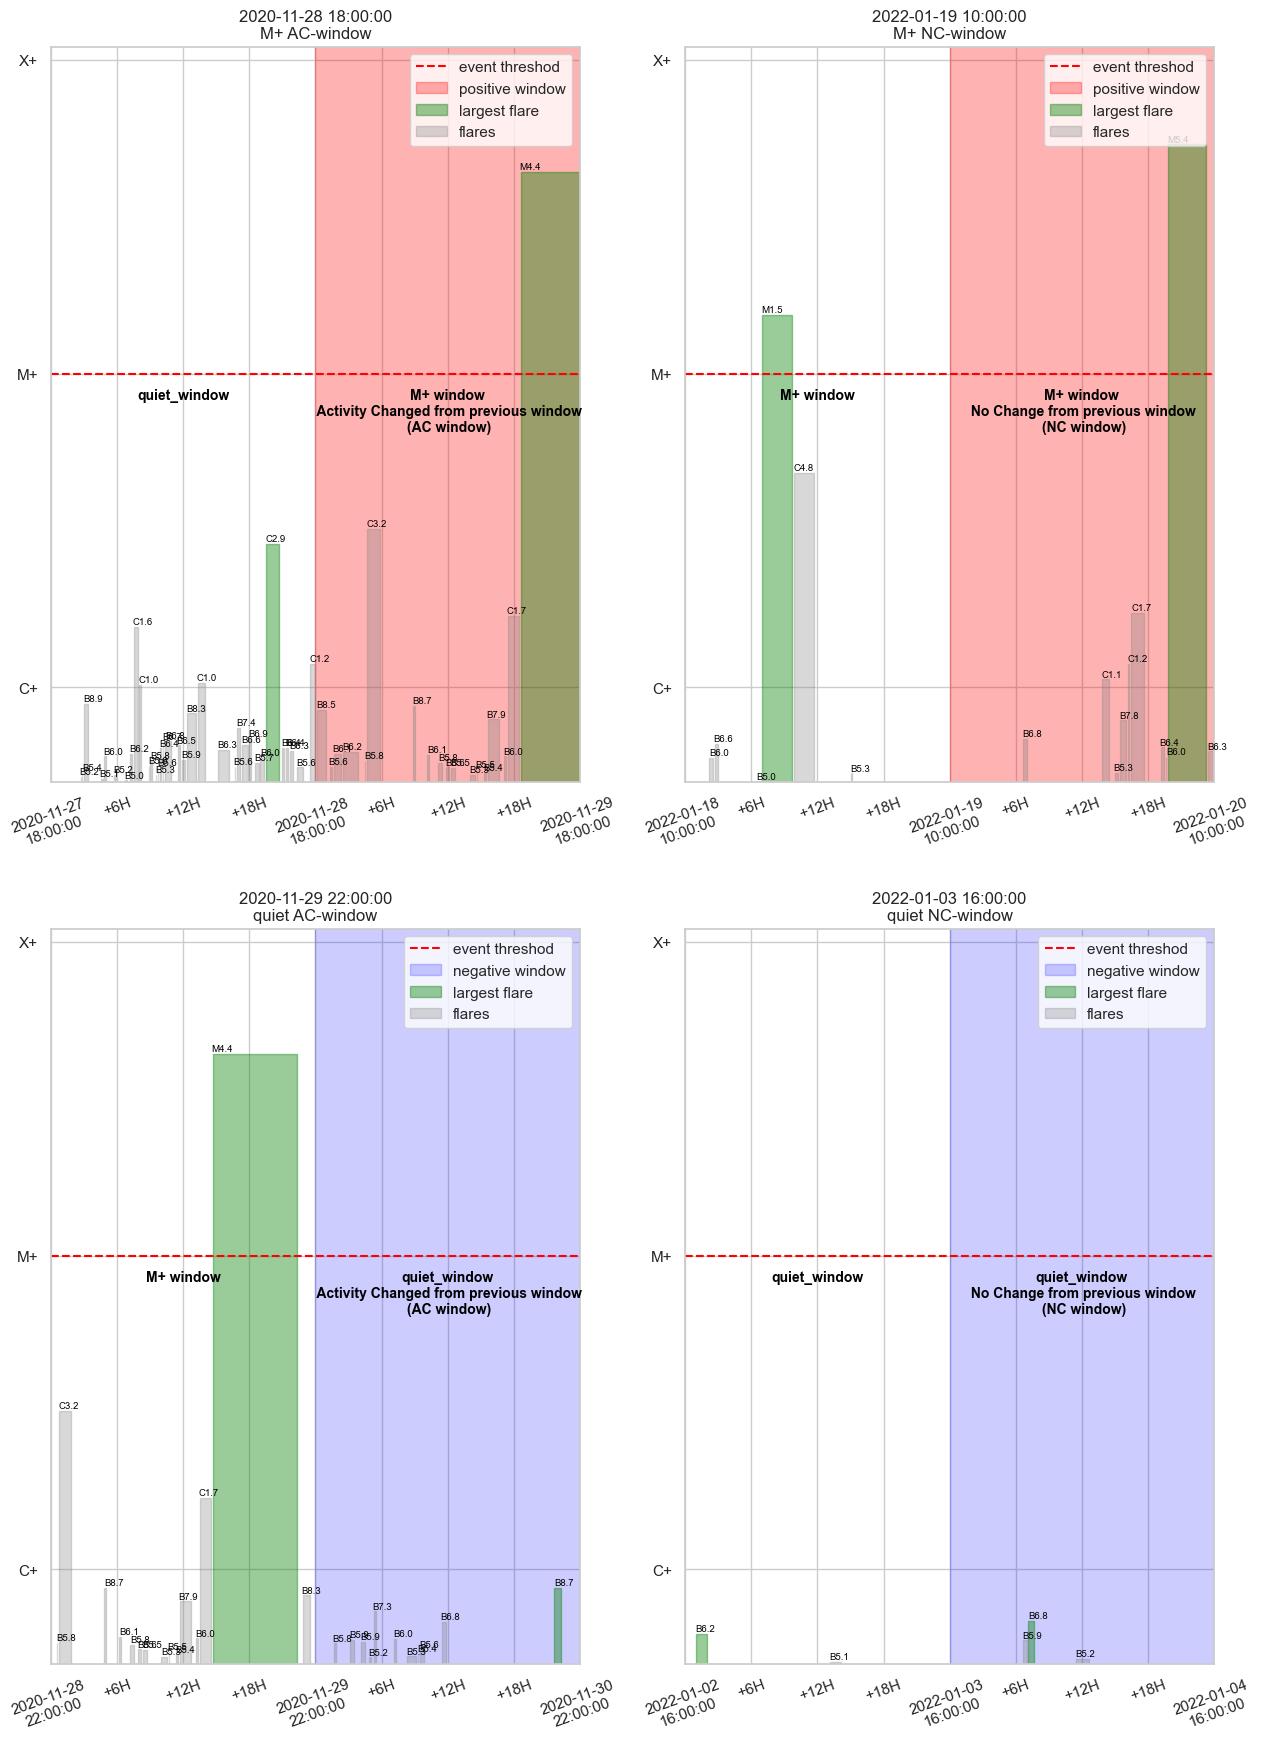

In [8]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15,21)

fig,  axs =  plt.subplots(2,2)


labelType  = 'M+'
xtick_freq = '10min'
label_freq = '6H'

no2Mdate = pd.to_datetime('2020-11-28 18:00:00')
M2Mdate = pd.to_datetime('2022-01-19 10:00:00')
M2nodate = pd.to_datetime('2020-11-29 22:00:00')
no2nodate = pd.to_datetime('2022-01-03 16:00:00')


_ = plotWindowLabel(windowDate     = no2Mdate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[0,0],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'M+ AC-window'
                )
flare = plotWindowLabel(windowDate     = M2Mdate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[0,1],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'M+ NC-window'
                )
_ = plotWindowLabel(windowDate     = M2nodate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[1,0],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'quiet AC-window'
                )
_ = plotWindowLabel(windowDate     = no2nodate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[1,1],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'quiet NC-window'
                )

## Limit cases checks

Checking that windows labels are consistent when events are close/overlapping to the windows boundariess

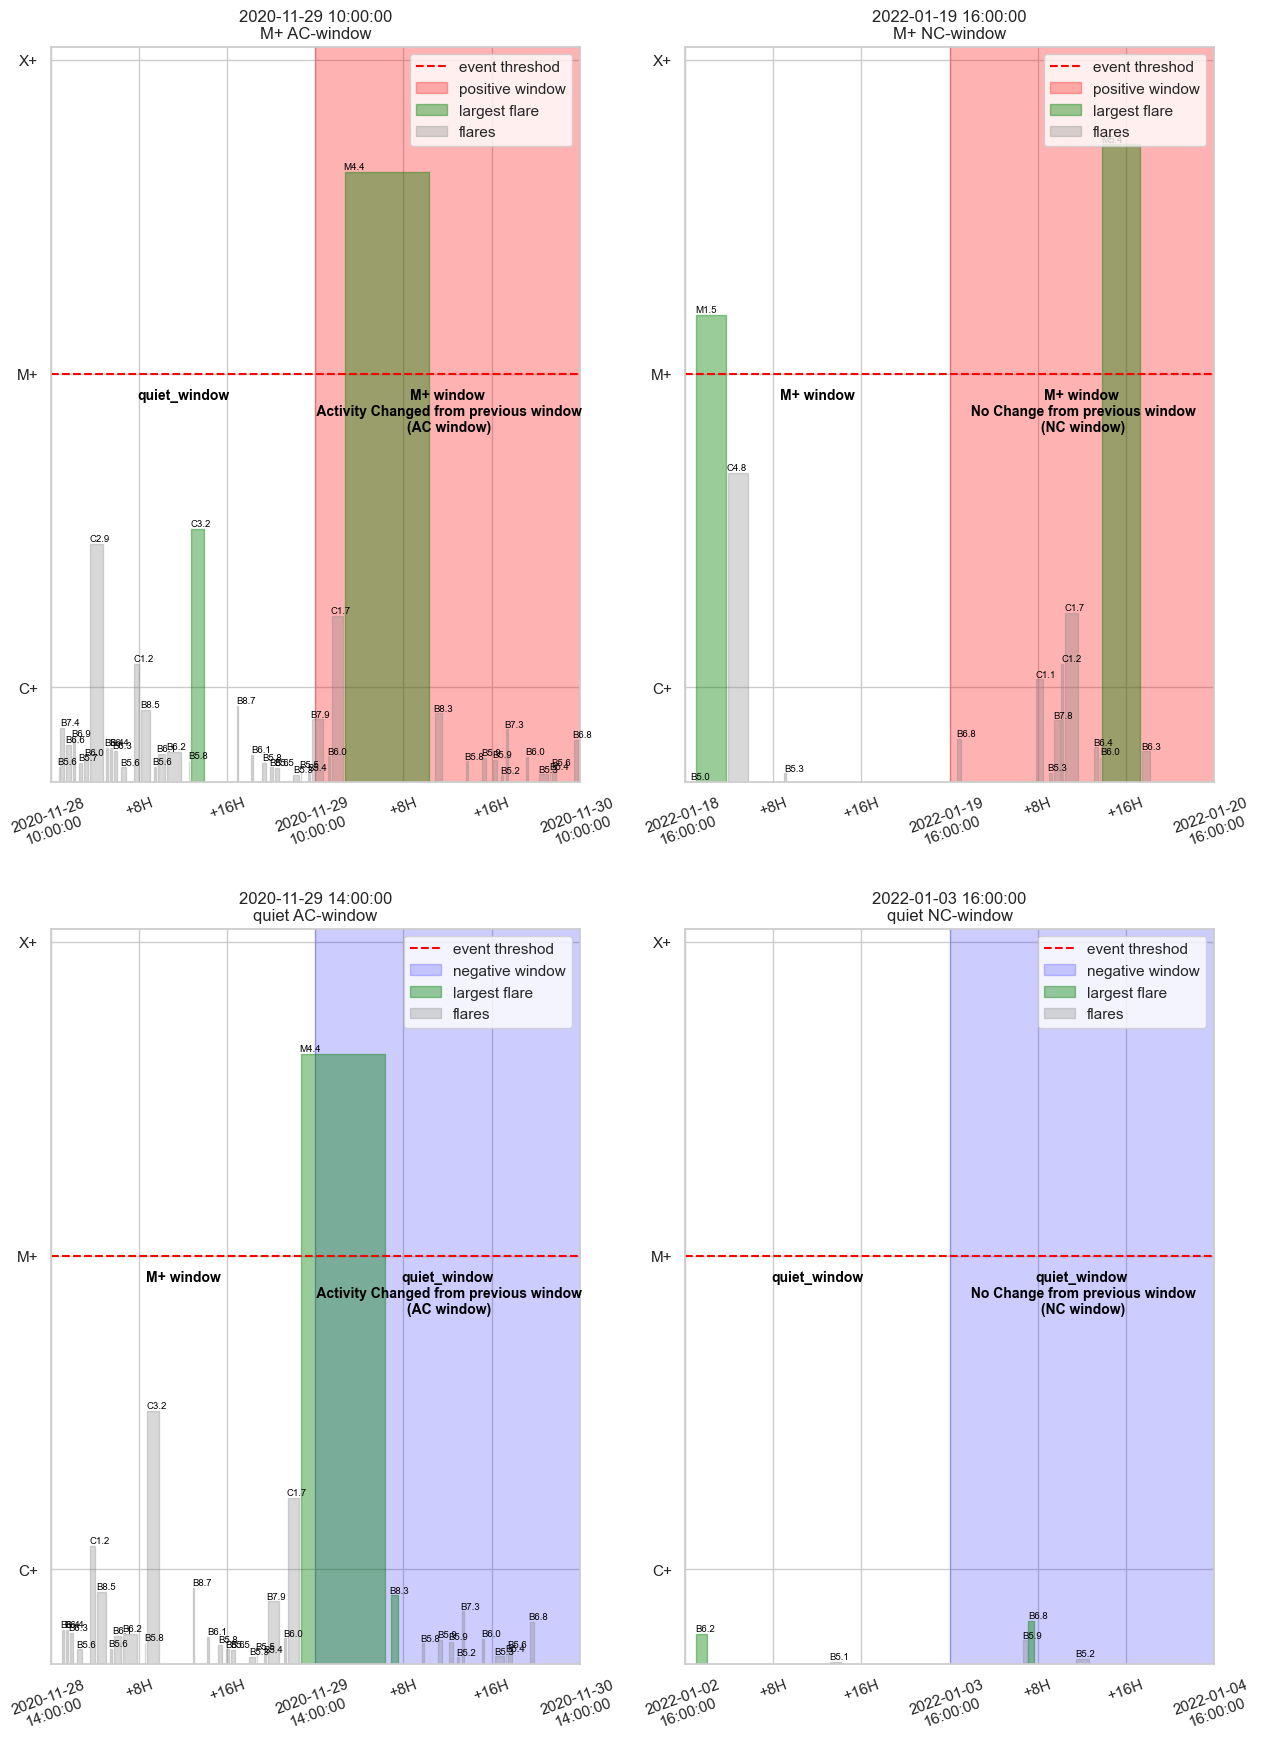

In [9]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15,21)

fig,  axs =  plt.subplots(2,2)


labelType  = 'M+'
xtick_freq = '10min'
label_freq = '8H'

no2Mdate = pd.to_datetime('2020-11-29 10:00:00')
M2Mdate = pd.to_datetime('2022-01-19 16:00:00')
M2nodate = pd.to_datetime('2020-11-29 14:00:00')
no2nodate = pd.to_datetime('2022-01-03 16:00:00')


_ = plotWindowLabel(windowDate = no2Mdate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[0,0],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'M+ AC-window'
                )
flare = plotWindowLabel(windowDate = M2Mdate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[0,1],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'M+ NC-window'
                )
_ = plotWindowLabel(windowDate = M2nodate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[1,0],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'quiet AC-window'
                )
_ = plotWindowLabel(windowDate     = no2nodate, 
                flCatalog      = flCatalog, 
                windows_label  = windows_pandas, 
                labelType      = labelType,
                ax             = axs[1,1],
                windows_size_h = 24,
                    xtick_freq = xtick_freq,
                    label_freq = label_freq,
                    extratitle = f'quiet NC-window'
                )

## Manual checks

Plot window at a specific date

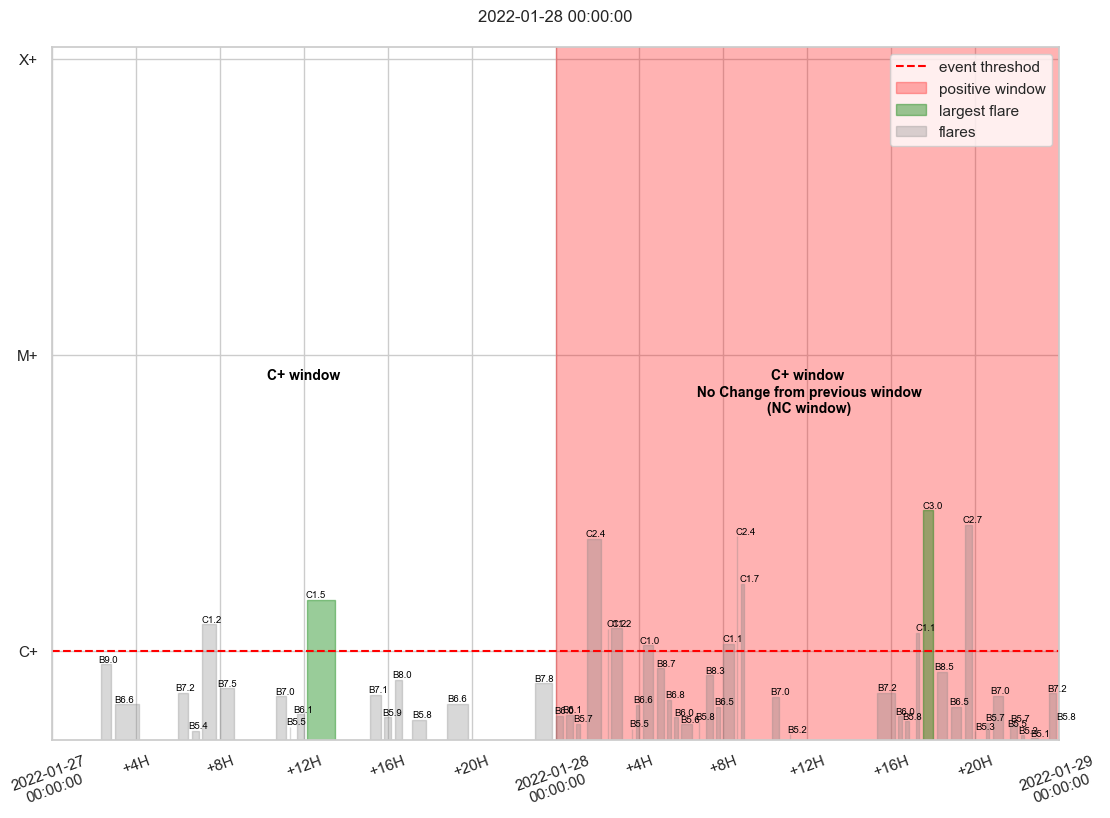

In [10]:
windowDate = pd.to_datetime('2022-01-28 00:00:00')
labelType  = 'C+'
label_freq = '4H'

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (13,9)
fig,  axs =  plt.subplots()

_ = plotWindowLabel(
      windowDate = windowDate, 
      flCatalog      = flCatalog, 
      windows_label  = windows_pandas, 
      labelType      = labelType,
      ax             = axs,
      windows_size_h = 24,
          xtick_freq = '10min',
          label_freq = label_freq
      )


# Persistence models performances

In [ ]:
cls = 'C+'

tp = ((windows_pandas[cls]==True) & (windows_pandas[f'{cls}_previous']==True)).sum()
tn = ((windows_pandas[cls]==False) & (windows_pandas[f'{cls}_previous']==False)).sum()
fp = ((windows_pandas[cls]==False) & (windows_pandas[f'{cls}_previous']==True)).sum()
fn = ((windows_pandas[cls]==True) & (windows_pandas[f'{cls}_previous']==False)).sum()

# proportion of positive events (positive event ratio)
phi = (tp+fn) / len(windows_pandas)
# activity change rate
chi = (windows_pandas[f'{cls}_AC']==True).sum() / len(windows_pandas)

tss = tp / (tp+fn) + tn / (tn+fp) - 1
f1 = 2*tp / (2*tp+fn+fp)
mcc = (tp*tn - fn*fp) / np.sqrt((tp+fn)*(tn+fn)*(tn+fp)*(tp+fp))

A12 = 1 - 0.5*chi/(phi*(1-phi)) # A12 formula from paper, must be equal to TSS and HSS

results = {
  'tss' : tss,
  'A12' : A12,
  'mcc' : mcc,
  'f1'  : f1,
  'phi' : phi,
  'chi' : chi
}
results

{'tss': 0.7276380477593214,
 'A12': 0.7276900049389528,
 'mcc': 0.7276769119452832,
 'f1': 0.8595694830868356,
 'phi': 0.4847517730496454,
 'chi': 0.13602836879432625}

In [ ]:
cls = 'M+'

tp = ((windows_pandas[cls]==True) & (windows_pandas[f'{cls}_previous']==True)).sum()
tn = ((windows_pandas[cls]==False) & (windows_pandas[f'{cls}_previous']==False)).sum()
fp = ((windows_pandas[cls]==False) & (windows_pandas[f'{cls}_previous']==True)).sum()
fn = ((windows_pandas[cls]==True) & (windows_pandas[f'{cls}_previous']==False)).sum()

# proportion of positive events (positive event ratio)
phi = (tp+fn) / len(windows_pandas)
# activity change rate
chi = (windows_pandas[f'{cls}_AC']==True).sum() / len(windows_pandas)

tss = tp / (tp+fn) + tn / (tn+fp) - 1
f1 = 2*tp / (2*tp+fn+fp)
mcc = (tp*tn - fn*fp) / np.sqrt((tp+fn)*(tn+fn)*(tn+fp)*(tp+fp))

A12 = 1 - 0.5*chi/(phi*(1-phi)) # A12 formula from paper, must be equal to TSS and HSS

results = {
  'tss' : tss,
  'A12' : A12,
  'mcc' : mcc,
  'f1'  : f1,
  'phi' : phi,
  'chi' : chi
}
results

{'tss': 0.44988169491945573,
 'A12': 0.44988169491945584,
 'mcc': 0.44988169491945584,
 'f1': 0.5251425609123899,
 'phi': 0.13680851063829788,
 'chi': 0.1299290780141844}